# Decision Trees

#### 🎯 Learning Goals

1. Understand the basics of **Decision Trees** and how to grow and prune them.
2. Learn how to implement **Decision Trees** in `scikit-learn` and how to interpret them.

In [1]:
# Load our libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Use a nicer style for plots
plt.style.use("seaborn-v0_8-muted")

___


## Growing the Tree
Let us first discuss how a regression tree is grown (the same guiding principles apply to classification trees!). Suppose we have a dataset with $n$ observations and $p$ features, i.e., $\mathcal{X} = \mathbb{R}^p$. We want to predict a continuous outcome, $\mathcal{Y} = \mathbb{R}$. The procedure of growing a tree can be divided into two main steps:

1. Split the feature space $\mathcal{X}$ into $J$ distinct regions, $R_1, R_2, \dots, R_J$.
2. For every region $R_1, R_2, \dots, R_J$, predict the mean of the outcome values in that region.

For instance, assume we grow a tree with $J=2$ regions, and we find that the mean of the outcomes in region $R_1$ is $\bar{y}_1=5$, whereas the mean of the outcomes in region $R_2$ is $\bar{y}_2 = 12$. Given a new observation, $\mathbf{x}$, we can now predict its outcome, $\hat{y}$, by finding the region it belongs to and predicting the mean of the outcomes in that region, i.e., $$\hat{f}(\mathbf{x}) = \begin{cases} \bar{y}_1 & \text{if } \mathbf{x} \in R_1 \\ \bar{y}_2 & \text{if } \mathbf{x} \in R_2 \end{cases} = \begin{cases} 5 & \text{if } \mathbf{x} \in R_1 \\ 12 & \text{if } \mathbf{x} \in R_2 \end{cases} $$


### Splitting the Feature Space

While the above procedure sounds easy enough, we are still missing some information to start growing our own trees. Importantly, we may ask the question: **how do we choose the regions** $R_1, R_2, \dots, R_J$?

Surely, we cannot possibly try out every split of the feature space into $J$ distinct regions. This is where we have to introduce a *top-down, greedy* approach: **recursive binary splitting**. We call the approach *top-down*, because we start at the top of the tree (at the root node) and split the feature space into two regions. Then, we repeat this process in each of the two resulting regions. We continue this process until a stopping criterion is reached, e.g., until a maximum tree depth is reached or until the number of observations in a region is below a certain threshold.

Here's a simplified outline of the procedure:

1. Iterate over all features $X_k$ for $k=1, 2, \dots p$.
    + For each feature $X_k$, iterate over all possible split points $s$.
        + Define $R_1 = \{\mathbf{x} \mid x_k \leq s\}$ and $R_2 = \{\mathbf{x} \mid x_k > s\}$.
        + Evaluate the loss function for the two resulting regions, $R_1$ and $R_2$.
    + Choose the feature $X_k$ and split point $s$ that minimize the loss function.
2. Repeat step 1, but instead of splitting the whole feature space, we split one of the two previously identified regions, $R_1$ and $R_2$ (the one which gives the best loss reduction).This yields a new region.
3. Repeat step 1 and 2 until a stopping criterion is reached (e.g., maximum tree depth or minimum number of observations in a region).

The animation below illustrates how changing split point $s$ (the dashed black line on the left-hand side plot) results in a different partitioning of the feature space (the region to the left of the dashed black line and the region to the right of the dashed black line). The right-hand side plot shows the loss function for each split point $s$. The split point $s$ that minimizes the loss function is chosen as the split point for the current feature $X_k$ (in this case it would result in roughly $s=8.25$, where the MSE is lowest)

![](https://jldc.ch/slides/img/dsf/tree_splitting.gif)

### Pruning the Tree

While a fully grown decision tree might flawlessly fit the training data, especially if we expand it to the point where each observation forms its own region, this would result in an overfitted model with poor generalization to new data. To avoid overfitting, we use **pruning** to simplify the model.

Although it might seem logical to employ cross-validation to assess various subtrees and their generalization errors, this process is computationally intensive due to the sheer number of potential subtrees. Hence, we use **cost-complexity pruning**—or **weakest link pruning**—to reduce the computational demands by evaluating only a key subset of possible subtrees.

Denote our fully grown tree as $T_0$. Here, we introduce a complexity parameter $\alpha \geq 0$, which helps us balance the tree's fit with its simplicity. For a given $\alpha$, there's an optimal subtree $T$ of $T_0$ that minimizes the equation: $$\sum_{m=1}^{|T|} \sum_{\mathbf{x} \in R_m} (y - \bar{y}_m)^2 + \alpha |T|,$$ where $|T|$ denotes the number of terminal nodes in $T$, $R_m$ represents the region defined by the $m^\text{th}$ split, and $\bar{y}_m$ is the mean response for region $R_m$.

Increasing $\alpha$ incrementally prunes the tree, trimming it down in a systematic manner. This process yields a sequence of increasingly simpler subtrees determined by the value of $\alpha$. The term $\alpha |T|$ functions like a regularizer, akin to the penalty term in Lasso regression &mdash; the larger $\alpha$ is, the greater the tree's simplification.

To find the ideal $\alpha$, we turn to cross-validation, similar to tuning Lasso or Ridge regularization parameters. The selected $\alpha$ leads us to a pruned tree that we can then use to make more reliable predictions on unseen test data.

In [2]:
# Import the regression tree from scikit-learn and a plotting helper
from sklearn.tree import DecisionTreeRegressor, plot_tree
# Import our train_test_split helper
from sklearn.model_selection import train_test_split

In [3]:
# Load our data
housing = pd.read_csv("data/ames_housing.csv")
housing.head()

,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,...,fence,misc_feature,misc_val,mo_sold,year_sold,sale_type,sale_condition,sale_price,longitude,latitude
0,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141,31770,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,No_Fence,NaN,0,5,2010,WD,Normal,215000,-93.619754,42.054035
1,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80,11622,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,Minimum_Privacy,NaN,0,6,2010,WD,Normal,105000,-93.619756,42.053014
2,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81,14267,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,No_Fence,Gar2,12500,6,2010,WD,Normal,172000,-93.619387,42.052659
3,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93,11160,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,...,No_Fence,NaN,0,4,2010,WD,Normal,244000,-93.617320,42.051245
4,Two_Story_1946_and_Newer,Residential_Low_Density,74,13830,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,Minimum_Privacy,NaN,0,3,2010,WD,Normal,189900,-93.638933,42.060899


In [4]:
# Inspect our dataset
housing.describe()

,lot_frontage,lot_area,year_built,year_remod_add,mas_vnr_area,bsmtfin_sf_1,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,first_flr_sf,...,enclosed_porch,three_season_porch,screen_porch,pool_area,misc_val,mo_sold,year_sold,sale_price,longitude,latitude
count,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,...,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000
mean,57.647782,10147.921843,1971.356314,1984.266553,101.096928,4.177474,49.705461,559.071672,1051.255631,1159.557679,...,23.011604,2.592491,16.002048,2.243345,50.635154,6.216041,2007.790444,180796.060068,-93.642897,42.034482
std,33.499441,7880.017759,30.245361,20.860286,178.634545,2.233372,169.142089,439.540571,440.968018,391.890885,...,64.139059,25.141331,56.087370,35.597181,566.344288,2.714492,1.316613,79886.692357,0.025700,0.018410
min,0.000000,1300.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000,-93.693153,41.986498
25%,43.000000,7440.250000,1954.000000,1965.000000,0.000000,3.000000,0.000000,219.000000,793.000000,876.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129500.000000,-93.660217,42.022088
50%,63.000000,9436.500000,1973.000000,1993.000000,0.000000,3.000000,0.000000,465.500000,990.000000,1084.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,160000.000000,-93.641806,42.034662
75%,78.000000,11555.250000,2001.000000,2004.000000,162.750000,7.000000,0.000000,801.750000,1301.500000,1384.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,213500.000000,-93.622113,42.049853
max,313.000000,215245.000000,2010.000000,2010.000000,1600.000000,7.000000,1526.000000,2336.000000,6110.000000,5095.000000,...,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000,-93.577427,42.063388


In [5]:
housing.isna().sum().sum()

np.int64(4599)

In [6]:
# Split our data intro features and targets
y = np.log(housing["sale_price"]) # Use the logarithm of the sale price
features = ["lot_frontage", "lot_area", "year_built", "pool_area"]
X = housing[features]

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=72)

In [7]:
# DecisionTreeRegressor is just another sklearn estimator, we can use it
# like we would any other model
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)

DecisionTreeRegressor()

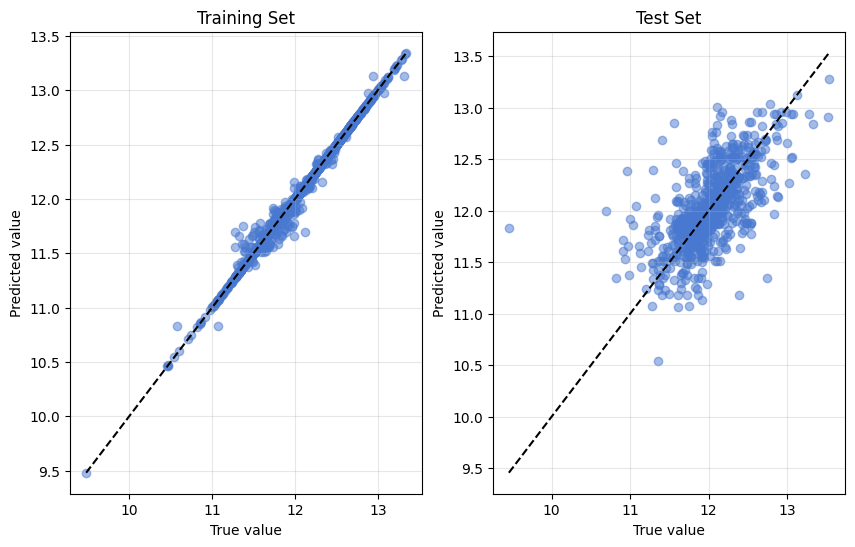

In [8]:
# Plot our predictions
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# Plot the training data
y_hat_train = tree.predict(X_train)
axs[0].scatter(y_train, y_hat_train, alpha=0.5, label="train")
# Plot a diagonal line
axs[0].plot(*[[np.minimum(y_train.min(), y_hat_train.min()), 
               np.maximum(y_train.max(), y_hat_train.max())] for _ in range(2)],
            color="black", ls="--")
axs[0].set_title("Training Set")

# Plot the test data
y_hat_test = tree.predict(X_test)
axs[1].scatter(y_test, y_hat_test, alpha=0.5, label="test")
# Plot a diagonal line
axs[1].plot(*[[np.minimum(y_test.min(), y_hat_test.min()), 
               np.maximum(y_test.max(), y_hat_test.max())] for _ in range(2)],
            color="black", ls="--")
axs[1].set_title("Test Set")

for ax in axs:
    ax.set_xlabel("True value")
    ax.set_ylabel("Predicted value")
    ax.grid(alpha=0.3)

Clearly, the tree is doing very well at predicting the housing prices on the training set. It's doing a decent job as well on the test set, but considering how well it does on the train set, we might suspect overfitting. Even more so since we have not specified any restriction on how the tree should be built.

We could plot the tree to get a better understanding of how the predictions work. In this case, however, the tree is very deep, and plotting it will crash our machines.

In [9]:
# Display the maximum depth of the tree. At each depth, the tree splits
# the data into two groups based on a threshold value for one of the
# features. 
tree.tree_.max_depth

24

#### ➡️ ✏️ Task 1

Observe the plot below, try changing `max_depth` parameter to 2, 3, or even 4. Avoid going much further as it will quickly break your Nuvolos session and you will have to restart it. You may need to play around with the figure size to properly read the plot.

Try to figure out what the different values in the plot mean. Can you try to explain how to read the plot to your classmate?

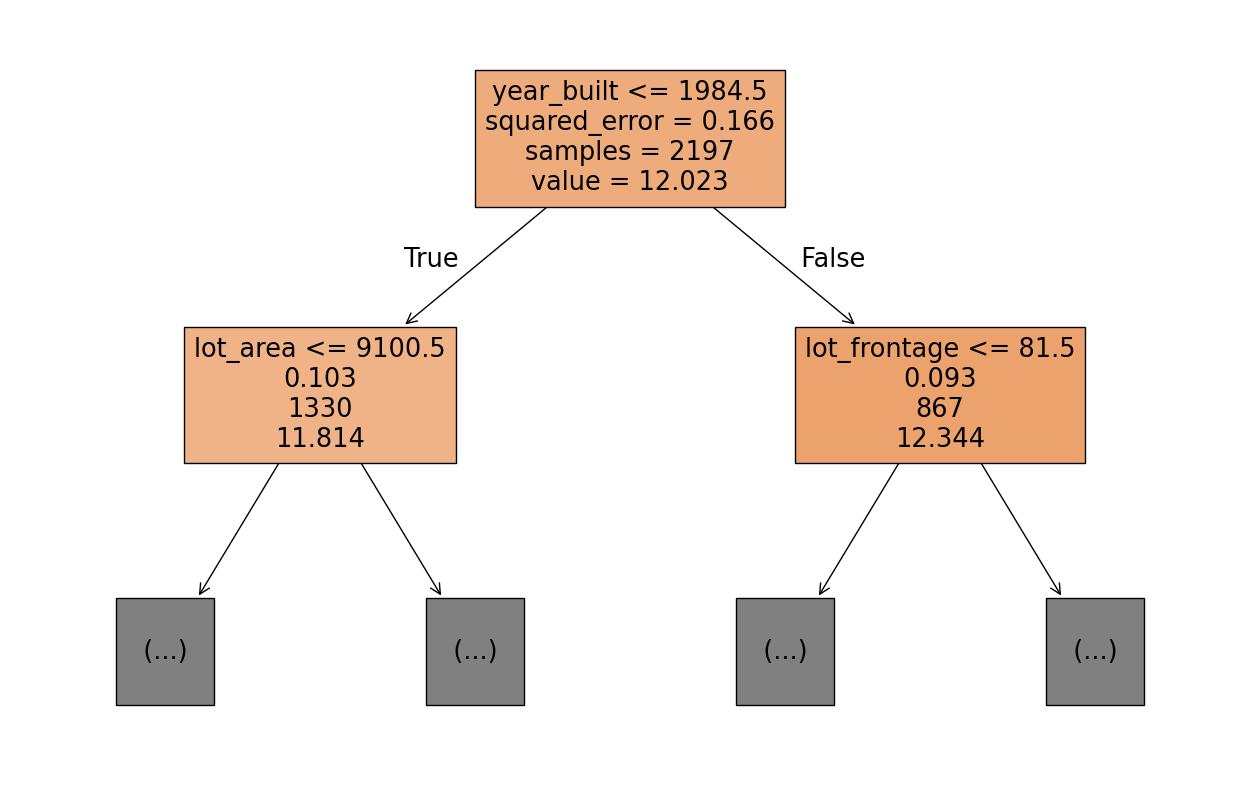

In [10]:
fig, ax = plt.subplots(figsize=(16, 10))
plot_tree(tree, label="root", filled=True, max_depth=1, 
          feature_names=features, ax=ax);

#### ➡️ ✏️ Task 2

To see the cost complexity pruning in action, implement a new estimator `tree_ccp` which repeats the code implemented above, but when creating the tree, use the `ccp_alpha` parameter and set it to `3e-3`. If you are unsure how to specify `ccp_alpha`, make sure to check the documentation of [`DecisionTreeRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html).

Finally, plot the new tree:
1. Plot the actual vs. predicted values like above
2. Plot the full tree structure (without restricting the `max_depth`) and compare it to the previous one. What do you notice?

In [12]:
tree_ccp = DecisionTreeRegressor(ccp_alpha=3e-3)
tree_ccp.fit(X_train, y_train)

# Show the max_depth of the tree
tree_ccp.tree_.max_depth

3

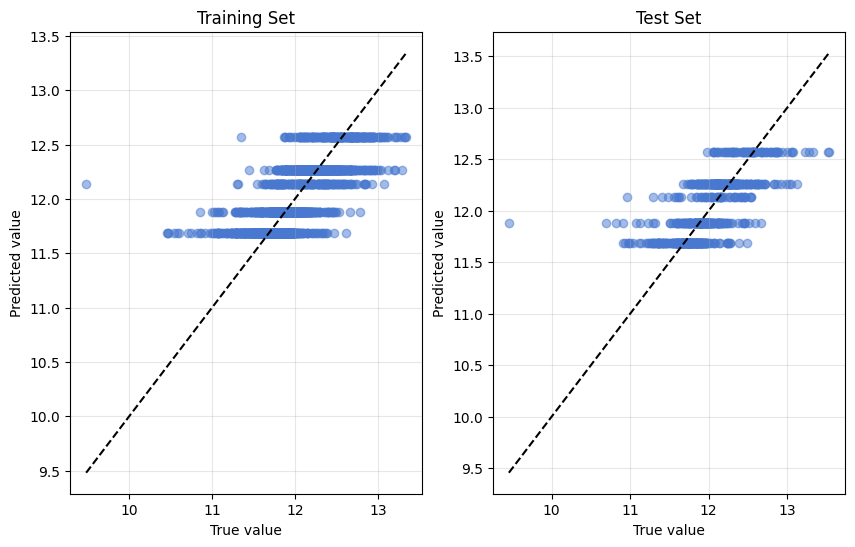

In [15]:
# Plot our predictions
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# Plot the training data
y_hat_train = tree_ccp.predict(X_train)
axs[0].scatter(y_train, y_hat_train, alpha=0.5, label="train")
# Plot a diagonal line
axs[0].plot(*[[np.minimum(y_train.min(), y_hat_train.min()), 
               np.maximum(y_train.max(), y_hat_train.max())] for _ in range(2)],
            color="black", ls="--")
axs[0].set_title("Training Set")

# Plot the test data
y_hat_test = tree_ccp.predict(X_test)
axs[1].scatter(y_test, y_hat_test, alpha=0.5, label="test")
# Plot a diagonal line
axs[1].plot(*[[np.minimum(y_test.min(), y_hat_test.min()), 
               np.maximum(y_test.max(), y_hat_test.max())] for _ in range(2)],
            color="black", ls="--")
axs[1].set_title("Test Set")

for ax in axs:
    ax.set_xlabel("True value")
    ax.set_ylabel("Predicted value")
    ax.grid(alpha=0.3)

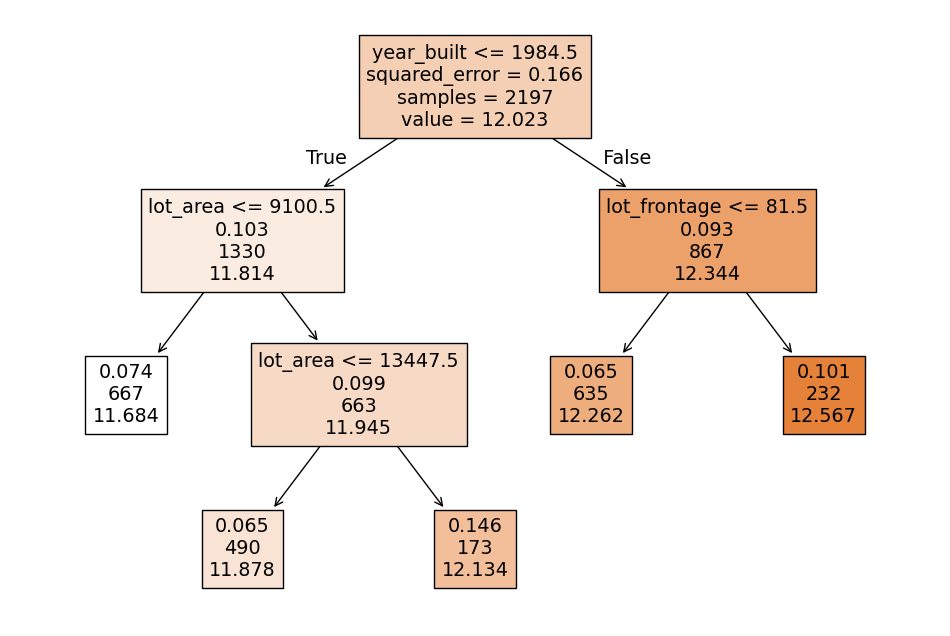

In [16]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_tree(tree_ccp, label="root", filled=True, 
          feature_names=features, ax=ax);

While we might have been overfitting when we didn't set the cost-complexity pruning, it seems we might be underfitting now. Let's try to find the optimal value for `ccp_alpha` using cross-validation.

In [17]:
# Import our tools for model selection
from sklearn.model_selection import cross_validate, KFold

In [66]:
# Specify our CV strategy
cv = KFold(n_splits=5, shuffle=True, random_state=72)

# Specify the values of cost-complexity parameter to try
alphas = np.logspace(-4, 0, 200)

scores = [] # Store the cross-validation scores
scores_std = [] # Store the standard deviations of the scores

# Perform cross-validation
for alpha in alphas:
    tree_cv = DecisionTreeRegressor(ccp_alpha=alpha)
    # Cross validate the tree, 
    cv_results = cross_validate(tree_cv, X_train, y_train, cv=cv, 
                                scoring="neg_mean_squared_error")
    scores.append(-cv_results["test_score"].mean())
    scores_std.append(cv_results["test_score"].std())

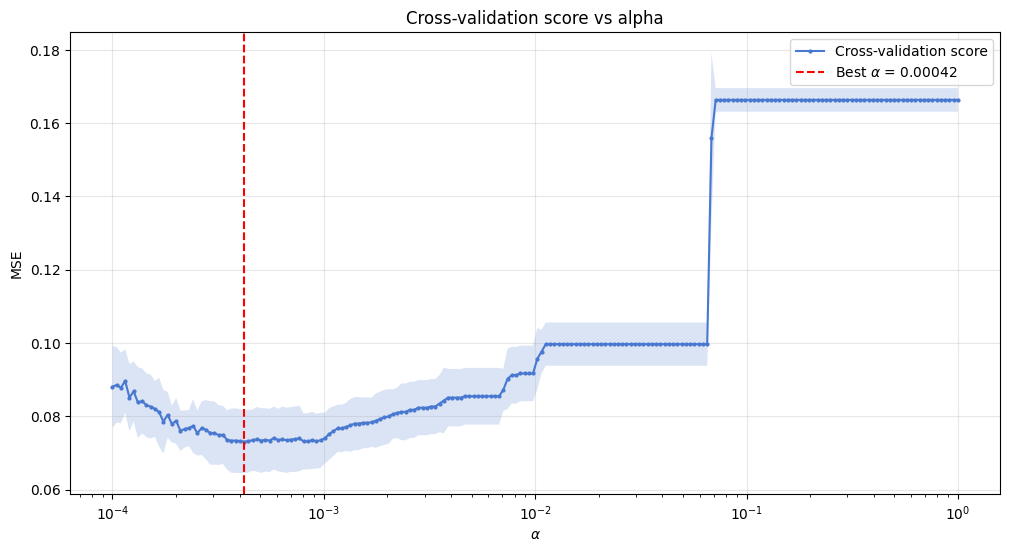

In [67]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(alphas, scores, '-o', label="Cross-validation score", markersize=2)
ax.fill_between(alphas, np.array(scores) - np.array(scores_std),
                np.array(scores) + np.array(scores_std), alpha=0.2)

# Plot best alpha
best_alpha = alphas[np.argmin(scores)]
ax.axvline(best_alpha, ls="--", color="red", label=f"Best $\\alpha$ = {best_alpha:.5f}")
ax.legend()


ax.set_xlabel("$\\alpha$")
ax.set_ylabel("MSE")
ax.set_xscale("log")
ax.set_title("Cross-validation score vs alpha")
ax.grid(alpha=0.3);


#### ➡️ ✏️ Task 3

Using the `ccp_alpha` value suggested by cross-validation, build a new tree. Compare the results of actual vs. predicted values and the mean-squared error with the trees we built before.

In [69]:
# Create a new tree with the best alpha
tree_best = DecisionTreeRegressor(ccp_alpha=best_alpha)

# Fit the tree
tree_best.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.00041987070844439096)

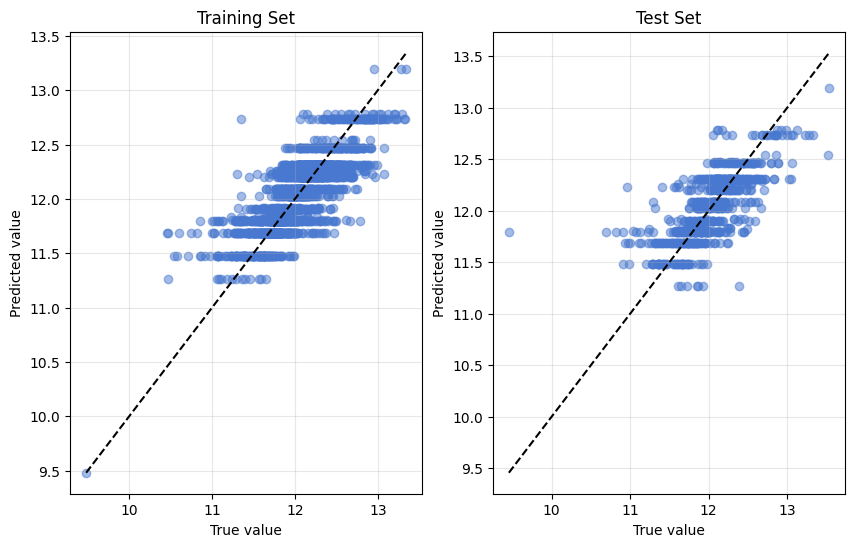

In [70]:
# Plot our predictions
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# Plot the training data
y_hat_train = tree_best.predict(X_train)
axs[0].scatter(y_train, y_hat_train, alpha=0.5, label="train")
# Plot a diagonal line
axs[0].plot(*[[np.minimum(y_train.min(), y_hat_train.min()), 
               np.maximum(y_train.max(), y_hat_train.max())] for _ in range(2)],
            color="black", ls="--")
axs[0].set_title("Training Set")

# Plot the test data
y_hat_test = tree_best.predict(X_test)
axs[1].scatter(y_test, y_hat_test, alpha=0.5, label="test")
# Plot a diagonal line
axs[1].plot(*[[np.minimum(y_test.min(), y_hat_test.min()), 
               np.maximum(y_test.max(), y_hat_test.max())] for _ in range(2)],
            color="black", ls="--")
axs[1].set_title("Test Set")

for ax in axs:
    ax.set_xlabel("True value")
    ax.set_ylabel("Predicted value")
    ax.grid(alpha=0.3)

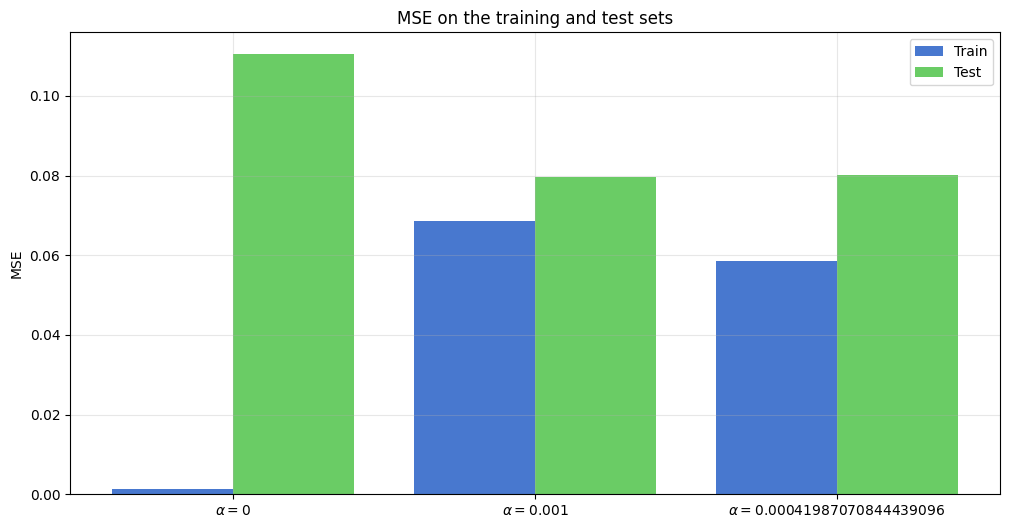

In [84]:
# Compare the MSEs
mses_train = [
    np.mean((y_train - tree.predict(X_train))**2),
    np.mean((y_train - tree_ccp.predict(X_train))**2),
    np.mean((y_train - tree_best.predict(X_train))**2)
]

mses_test = [
    np.mean((y_test - tree.predict(X_test))**2),
    np.mean((y_test - tree_ccp.predict(X_test))**2),
    np.mean((y_test - tree_best.predict(X_test))**2)
]


fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(np.arange(3) - 0.2, mses_train, width=0.4, label="Train")
ax.bar(np.arange(3) + 0.2, mses_test, width=0.4, label="Test")
ax.set_xticks(np.arange(3))
ax.set_xticklabels(["$\\alpha = 0$", "$\\alpha = 0.001$", f"$\\alpha = {best_alpha}$"])
ax.set_ylabel("MSE")
ax.set_title("MSE on the training and test sets")
ax.legend()
ax.grid(alpha=0.3);
